In [83]:
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import h5py
from sklearn.model_selection import train_test_split
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

In [8]:
# 读取灰度图并归一化
def read_and_preprocess(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"无法读取图像：{image_path}")
    return image.astype(np.float32) / 255.0

In [9]:
def read_and_preprocess(image_path):
    """
    读取图像并对图像进行预处理。
    功能：
    1. 以灰度模式读取图像。
    2. 检查图像是否成功读取，若失败则抛出异常。
    3. 将图像数据转换为 float32 类型，并归一化到 [0, 1] 范围内。
    
    参数:
      image_path: 图像文件的路径。
      
    返回:
      归一化后的图像数组（灰度图），数据类型为 np.float32。
    """
    # 使用 OpenCV 以灰度模式读取图像
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # 如果图像未能正确读取，抛出异常
    if image is None:
        raise ValueError(f"无法读取图像：{image_path}")
    # 将图像转换为 float32，并将像素值归一化至 [0, 1]
    return image.astype(np.float32) / 255.0

def generate_heatmap(volume_shape, motor_coords, sigma=1):
    """
    根据给定的体数据尺寸和细菌鞭毛电机的坐标生成高斯热图。
    
    如果存在多个鞭毛电机，则对每个鞭毛电机生成高斯核，并取各点上的最大值作为最终热图的数值。
    若某个样本中没有鞭毛电机（坐标为 (-1, -1, -1)），则该样本的热图保持为全零。
    
    参数:
      volume_shape: 三维体数据的尺寸，格式为 (深度, 高度, 宽度)。
      motor_coords: 细菌鞭毛电机坐标的列表，每个坐标为 (z, y, x) 形式。
      sigma: 高斯核的标准差（默认值为 1）。
      
    返回:
      生成的高斯热图，为一个与体数据尺寸相同的 numpy 数组。
    """
    # 初始化热图，全零数组，数据类型为 np.float32
    heatmap = np.zeros(volume_shape, dtype=np.float32)
    
    # 为生成三维高斯核准备坐标范围
    z_range = np.arange(volume_shape[0])  # 深度方向的坐标
    y_range = np.arange(volume_shape[1])  # 高度方向的坐标
    x_range = np.arange(volume_shape[2])  # 宽度方向的坐标
    
    # 利用 np.meshgrid 生成三维坐标网格，索引顺序为 (z, y, x)
    Z, Y, X = np.meshgrid(z_range, y_range, x_range, indexing='ij')
    
    # 对于每个细菌鞭毛电机的坐标，生成对应的高斯核
    for coord in motor_coords:
        # 如果该样本中没有鞭毛电机（坐标为 (-1, -1, -1)），跳过该样本
        if coord[0] == -1:
            continue
        # 计算当前坐标处的三维高斯分布
        gauss = np.exp(-((Z - coord[0])**2 + (Y - coord[1])**2 + (X - coord[2])**2) / (2 * sigma**2))
        # 将生成的高斯分布与已有的热图逐点取最大值，确保若有多个电机，其响应不会相互叠加，而只取最高的贡献
        heatmap = np.maximum(heatmap, gauss)
    return heatmap

In [10]:
train_dir = "train"                             # 训练图像文件夹
labels_csv = "train_labels.csv"                 # 标签 CSV 文件
save_dir = "processed_npz"                      # 输出 npz 的文件夹
os.makedirs(save_dir, exist_ok=True)

In [11]:
# 加载标签和 tomogram 列表
labels_df = pd.read_csv(labels_csv)
tomo_ids = sorted(os.listdir(train_dir))

In [12]:
# ==== 主处理函数 ====
def preprocess_and_save_npz(tomo_id, max_slices=32):
    out_path = os.path.join(save_dir, f"{tomo_id}.npz")
    if os.path.exists(out_path):
        return False  # 跳过已处理

    tomo_path = os.path.join(train_dir, tomo_id)
    slice_files = sorted(glob.glob(os.path.join(tomo_path, '*.jpg')))
    if len(slice_files) < max_slices:
        return False  # 太短跳过

    df_tomo = labels_df[labels_df['tomo_id'] == tomo_id]
    motor_coords = [(int(r['Motor axis 0']), int(r['Motor axis 1']), int(r['Motor axis 2'])) for _, r in df_tomo.iterrows()]
    if not motor_coords:
        motor_coords = [(-1, -1, -1)]

    motor_zs = [z for z, _, _ in motor_coords if z >= 0]
    center_z = int(np.mean(motor_zs)) if motor_zs else len(slice_files) // 2
    start_z = max(0, center_z - max_slices // 2)
    end_z = min(len(slice_files), start_z + max_slices)
    start_z = end_z - max_slices
    start_z = max(0, start_z)
    selected_files = slice_files[start_z:end_z]

    slices = [read_and_preprocess(f) for f in selected_files]
    volume = np.stack(slices, axis=0)[..., np.newaxis]

    corrected_coords = [(z - start_z, y, x) for z, y, x in motor_coords if start_z <= z < end_z] or [(-1, -1, -1)]
    heatmap = generate_heatmap(volume.shape[:3], corrected_coords, sigma=1)[..., np.newaxis]

    np.savez_compressed(out_path, volume=volume, heatmap=heatmap)
    return True  # 成功处理

# ==== 批处理带进度条与统计 ====
success_count = 0
for tomo_id in tqdm(tomo_ids, desc="Processing tomograms"):
    try:
        success = preprocess_and_save_npz(tomo_id)
        if success:
            success_count += 1
    except Exception as e:
        print(f"Error processing {tomo_id}: {e}")

print(f"\n共成功生成 {success_count} 个 .npz 文件，保存在 '{save_dir}/'")

Processing tomograms: 100%|██████████| 648/648 [1:51:20<00:00, 10.31s/it]  


共成功生成 648 个 .npz 文件，保存在 'processed_npz/'


In [20]:
# === 模型结构：UNet-like 3D CNN ===
def build_3d_localization_model(input_shape=(32, None, None, 1)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    x1 = tf.keras.layers.Conv3D(32, 3, activation='relu', padding='same')(inputs)
    x1 = tf.keras.layers.Conv3D(32, 3, activation='relu', padding='same')(x1)
    p1 = tf.keras.layers.MaxPooling3D(pool_size=2)(x1)

    x2 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same')(p1)
    x2 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same')(x2)
    p2 = tf.keras.layers.MaxPooling3D(pool_size=2)(x2)

    x3 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same')(p2)
    x3 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same')(x3)

    # Decoder
    u1 = tf.keras.layers.UpSampling3D(size=2)(x3)
    u1 = tf.keras.layers.Concatenate()([u1, x2])
    x4 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same')(u1)
    x4 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same')(x4)

    u2 = tf.keras.layers.UpSampling3D(size=2)(x4)
    u2 = tf.keras.layers.Concatenate()([u2, x1])
    x5 = tf.keras.layers.Conv3D(32, 3, activation='relu', padding='same')(u2)
    x5 = tf.keras.layers.Conv3D(32, 3, activation='relu', padding='same')(x5)

    outputs = tf.keras.layers.Conv3D(1, kernel_size=1, activation='sigmoid')(x5)

    return tf.keras.Model(inputs, outputs)

model = build_3d_localization_model(input_shape=(32, 64, 64, 1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 64, 64, 1)]      0         []                            
                                                                                                  
 conv3d_22 (Conv3D)          (None, 32, 64, 64, 32)       896       ['input_3[0][0]']             
                                                                                                  
 conv3d_23 (Conv3D)          (None, 32, 64, 64, 32)       27680     ['conv3d_22[0][0]']           
                                                                                                  
 max_pooling3d_4 (MaxPoolin  (None, 16, 32, 32, 32)       0         ['conv3d_23[0][0]']           
 g3D)                                                                                       

In [81]:
# === Resize 函数（统一大小） ===
def resize_volume(vol, target_shape=(32, 128, 128, 1)):
    vol = tf.convert_to_tensor(vol)
    vol = tf.image.resize(vol, size=target_shape[1:3])  # resize Y, X
    vol = tf.reshape(vol, target_shape)
    return vol

# === 数据加载 + resize ===
def load_npz_dataset(npz_paths, target_shape=(32, 128, 128, 1)):
    def generator():
        for path in npz_paths:
            data = np.load(path)
            v = data["volume"]
            h = data["heatmap"]
            yield resize_volume(v, target_shape), resize_volume(h, target_shape)

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=target_shape, dtype=tf.float32),
            tf.TensorSpec(shape=target_shape, dtype=tf.float32)
        )
    )

# === 数据准备 ===
all_npz = sorted(glob("processed_npz/*.npz"))
train_npz, val_npz = train_test_split(all_npz, test_size=0.2, random_state=42)

train_dataset = load_npz_dataset(train_npz).batch(2).prefetch(tf.data.AUTOTUNE)
val_dataset = load_npz_dataset(val_npz).batch(2).prefetch(tf.data.AUTOTUNE)

# === 构建和训练模型 ===
model = build_3d_localization_model(input_shape=(32, 128, 128, 1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True),
]

history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=callbacks)


Epoch 1/10
259/259 [==============================] - 1650s 6s/step - loss: 0.0016 - mae: 0.0035 - val_loss: 1.1666e-07 - val_mae: 3.8471e-07
Epoch 2/10


c:\Users\isaac\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


259/259 [==============================] - 1524s 6s/step - loss: 1.0115e-07 - mae: 3.4922e-07 - val_loss: 1.1666e-07 - val_mae: 3.8471e-07
Epoch 3/10
259/259 [==============================] - 1527s 6s/step - loss: 1.0115e-07 - mae: 3.4922e-07 - val_loss: 1.1666e-07 - val_mae: 3.8471e-07
Epoch 4/10
259/259 [==============================] - 1529s 6s/step - loss: 1.0115e-07 - mae: 3.4922e-07 - val_loss: 1.1666e-07 - val_mae: 3.8471e-07
Epoch 5/10
259/259 [==============================] - 1533s 6s/step - loss: 1.0115e-07 - mae: 3.4922e-07 - val_loss: 1.1666e-07 - val_mae: 3.8471e-07
Epoch 6/10
259/259 [==============================] - 1531s 6s/step - loss: 1.0115e-07 - mae: 3.4922e-07 - val_loss: 1.1666e-07 - val_mae: 3.8471e-07


In [52]:
all_npz = sorted(glob("processed_npz/*.npz"))
_, val_npz = train_test_split(all_npz, test_size=0.2, random_state=42)
def plot_3d_heatmap(npz_path, threshold=0.1):
    """
    可视化一个 3D heatmap 的结构，展示哪些 voxel 的值大于阈值。

    参数:
        npz_path: 指定的 .npz 文件路径
        threshold: 最小值过滤（小于此值不显示）
    """
    data = np.load(npz_path)
    heatmap = np.squeeze(data["heatmap"])  # shape: (Z, H, W)

    # 创建 mask：只显示高于 threshold 的位置
    mask = heatmap > threshold
    z, y, x = mask.nonzero()
    values = heatmap[z, y, x]

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    img = ax.scatter(x, y, z, c=values, cmap='hot', s=5)
    ax.set_title(f"3D Heatmap: {os.path.basename(npz_path)}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    fig.colorbar(img, ax=ax, shrink=0.6)
    plt.tight_layout()
    plt.show()

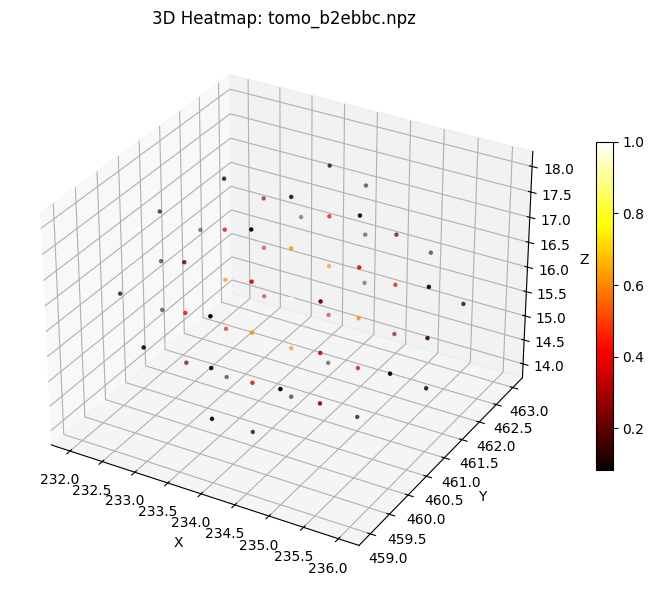

In [78]:
plot_3d_heatmap(val_npz[5], threshold=0.05)

In [79]:
def print_heatmap_peaks(npz_paths, n=5):
    """
    打印前 n 个 heatmap 中最大值的位置 (z, y, x) 和对应的值。

    参数:
        npz_paths: heatmap 所在的 .npz 文件路径列表
        n: 要打印的样本数量
    """
    for path in npz_paths[:n]:
        data = np.load(path)
        hmap = np.squeeze(data["heatmap"])  # 形状为 (Z, H, W)
        max_value = np.max(hmap)
        zyx = np.unravel_index(np.argmax(hmap), hmap.shape)
        print(f"{os.path.basename(path)} → peak at ZYX = {zyx}, value = {max_value:.5f}")

In [80]:
print_heatmap_peaks(val_npz, n=8)

tomo_fbb49b.npz → peak at ZYX = (0, 0, 0), value = 0.00000
tomo_56b9a3.npz → peak at ZYX = (16, 299, 498), value = 1.00000
tomo_e72e60.npz → peak at ZYX = (0, 0, 0), value = 0.00000
tomo_abbd3b.npz → peak at ZYX = (0, 0, 0), value = 0.00000
tomo_1da0da.npz → peak at ZYX = (0, 0, 0), value = 0.00000
tomo_b2ebbc.npz → peak at ZYX = (16, 461, 234), value = 1.00000
tomo_493bea.npz → peak at ZYX = (16, 380, 136), value = 1.00000
tomo_331130.npz → peak at ZYX = (16, 553, 323), value = 1.00000


In [96]:
# ==== 参数 ====
test_dir = "test"
model_path = "best_model.h5"
submission_csv = "sample_submission.csv"
target_shape = (32, 128, 128, 1)
stride = 16
cutoff = 0.001

# ==== 加载模型 ====
model = tf.keras.models.load_model(model_path, compile=False)

# ==== 工具函数 ====
def read_and_preprocess(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return img.astype(np.float32) / 255.0

def resize_volume(vol, target_shape=(32, 128, 128, 1)):
    vol = tf.convert_to_tensor(vol)
    vol = tf.image.resize(vol, size=target_shape[1:3])  # 只 resize Y, X
    vol = tf.reshape(vol, target_shape)
    return vol

# ==== 滑动窗口预测单个 tomogram ====
def predict_motor_with_sliding_window(tomo_path, model, target_shape, stride=16, cutoff=0.01):
    slice_files = sorted(glob.glob(os.path.join(tomo_path, "*.jpg")))
    total_slices = len(slice_files)
    if total_slices < 32:
        return (-1, -1, -1)

    best_score = -np.inf
    best_coord = (-1, -1, -1)

    for start_z in range(0, total_slices - 32 + 1, stride):
        end_z = start_z + 32
        slices = [read_and_preprocess(f) for f in slice_files[start_z:end_z]]
        volume = np.stack(slices, axis=0)[..., np.newaxis]

        resized = resize_volume(volume, target_shape)
        resized = tf.expand_dims(resized, axis=0)  # 增加 batch 维度

        pred = model.predict(resized, verbose=0)[0]
        pred = np.squeeze(pred)  # (32, H, W)

        maxval = np.max(pred)
        if maxval > best_score:
            z, y, x = np.unravel_index(np.argmax(pred), pred.shape)
            best_score = maxval
            best_coord = (start_z + z, y, x)

    return best_coord if best_score >= cutoff else (-1, -1, -1)

# ==== 批量预测并保存 ====
def predict_all_test_sliding(test_dir, model, target_shape, stride, cutoff, save_csv):
    results = []
    for tomo_id in sorted(os.listdir(test_dir)):
        tomo_path = os.path.join(test_dir, tomo_id)
        coord = predict_motor_with_sliding_window(tomo_path, model, target_shape, stride, cutoff)
        results.append((tomo_id, *coord))
        print(f"{tomo_id}: predicted {coord}")
    
    df = pd.DataFrame(results, columns=["tomo_id", "Motor axis 0", "Motor axis 1", "Motor axis 2"])
    df.to_csv(save_csv, index=False)
    print(f"Done. Saved submission to '{save_csv}'")

# ==== 执行 ====
predict_all_test_sliding(
    test_dir=test_dir,
    model=model,
    target_shape=target_shape,
    stride=stride,
    cutoff=cutoff,
    save_csv=submission_csv
)

tomo_003acc: predicted (-1, -1, -1)
tomo_00e047: predicted (-1, -1, -1)
tomo_01a877: predicted (-1, -1, -1)
Done. Saved submission to 'sample_submission.csv'
